# Create Time series figures to hopefully show what having theta or no theta looks like

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio

import mat73

from fooof import FOOOFGroup
from fooof.utils import trim_spectrum
from fooof.analysis import get_band_peak_fg
from neurodsp import spectral
from neurodsp import filt


from colourfulbirds.exp2_settings import (
    SETS, FREQ_RANGE, THETA, ALPHA, START_BAS, END_BAS, START_RET, END_RET
)

# from colourfulbirds.exp1_EEGperCondition import load_data as exp1_load_data
# from colourfulbirds.exp2_EEGperCondition import load_data as exp2_load_data


# Default figure size larger! 
figure = {'figsize': (15,5)}
plt.rc('figure', **figure)
sns.set_context('talk')

## Functions

In [44]:
def plot_high_low(eeg, n_idx, title):

    # plot settings
    lw = 4

    # Get the time axis and sampling frequency
    time = eeg['eeg']['time_long']
    sfreq = int(eeg['eeg']['settings']['srate'])

    # Grab data from frontal channels of analysis cluster
    eeg_fz = eeg['eeg']['data'][0, :, 18, :]
    # eeg_f3 = eeg['eeg']['data'][0, :, 2, :]
    # eeg_f4 = eeg['eeg']['data'][0, :, 3, :]

    # Baseline the data
    time_min200 = np.where(time == -200)[0][0]
    time_0 = np.where(time == 0)[0][0]
    eeg_fz_bas_period = eeg_fz[:, time_min200:time_0].mean(axis=1)
    eeg_fz_bas = eeg_fz - eeg_fz_bas_period.reshape(-1,1)

    # Create welches spectrum
    if np.isnan(eeg_fz_bas).any():
        eeg_fz_bas = eeg_fz_bas[~np.isnan(eeg_fz_bas).any(axis=1)]
    
    freq_fz, psd_fz = spectral.compute_spectrum(eeg_fz_bas, sfreq,
            method = 'welch', avg_type = 'mean', nperseg = sfreq)
        
    # initialize fooof + set settings
    fg = FOOOFGroup(**SETS)

    # Fooof it
    fg.fit(freq_fz, psd_fz, FREQ_RANGE, n_jobs= -1)

    # Find Peak heights
    periodic_theta = get_band_peak_fg(fg, THETA) # periodic params (cf, power, bandwidth)
    theta_power = periodic_theta[:,1]
    periodic_alpha = get_band_peak_fg(fg, ALPHA) # periodic params (cf, power, bandwidth)
    alpha_power = periodic_alpha[:,1]

    # Clean the data --> NaN to 0
    theta_power_cl = np.nan_to_num(theta_power)
    alpha_power_cl = np.nan_to_num(alpha_power)

    # Get indices of the 10 trials with highest theta power (according to specparam)
    n = 10
    theta_high_10 = np.argpartition(theta_power_cl, n)[-n:]
    theta_low_10 = np.argpartition(theta_power_cl, n)[n:]
    # theta_low_10 = np.random.choice(np.where(theta_power_cl == 0)[0], size=n, replace=False)

    alpha_high_10 = np.argpartition(alpha_power_cl, n)[-n:]
    alpha_low_10 = np.argpartition(alpha_power_cl, n)[n:]
    # alpha_low_10 = np.random.choice(np.where(alpha_power_cl == 0)[0], size=n, replace=False)

    # low pass filter to get rid of high freq noise
    eeg_fz_bas_low = filt.filter_signal(eeg_fz_bas, sfreq, pass_type='lowpass', f_range=30,
                                        filter_type='fir', n_cycles=3, remove_edges=True)

    eeg_fz_bas_theta = filt.filter_signal(eeg_fz_bas, sfreq, pass_type='bandpass', f_range=THETA, 
                                        filter_type='fir', n_cycles=3, remove_edges=True)

    eeg_fz_bas_alpha = filt.filter_signal(eeg_fz_bas, sfreq, pass_type='bandpass', f_range=ALPHA, 
                                        filter_type='fir', n_cycles=3, remove_edges=True)
    
    # cut time axis
    time_min1200 = np.where(time == -1200)[0][0]
    time_plus1600 = np.where(time == 1600)[0][0]    
    time_axis_cut = time[time_min1200:time_plus1600]
    
    # Get the highest 10 and lowest 10 trials of theta and alpha power
    theta_high = eeg_fz_bas_low[theta_high_10, time_min1200:time_plus1600]
    theta_low = eeg_fz_bas_low[theta_low_10, time_min1200:time_plus1600]
    theta_high_filt = eeg_fz_bas_theta[theta_high_10, time_min1200:time_plus1600]
    theta_low_filt = eeg_fz_bas_theta[theta_low_10, time_min1200:time_plus1600]

    alpha_high = eeg_fz_bas_low[alpha_high_10, time_min1200:time_plus1600]
    alpha_low = eeg_fz_bas_low[alpha_low_10, time_min1200:time_plus1600]
    alpha_high_filt = eeg_fz_bas_alpha[alpha_high_10, time_min1200:time_plus1600]
    alpha_low_filt = eeg_fz_bas_alpha[alpha_low_10, time_min1200:time_plus1600]

    

    fig, ax = plt.subplots(2, figsize=(15, 8))

    # plot Filtered and bandpassed in same plot
#     ax[0].plot(time_axis_cut, theta_high[n_idx], color='#7b3294')
#     ax[0].plot(time_axis_cut, theta_high_filt[n_idx], color='#008837')
#     ax[1].plot(time_axis_cut, theta_low[n_idx], color='#7b3294')
#     ax[1].plot(time_axis_cut, theta_low_filt[n_idx], color='#008837')

    # plot Filtered and bandpassed in different plots to compare between high and low
    ax[0].plot(time_axis_cut, theta_high[n_idx], color='#7b3294', linewidth=lw, label='High')
    ax[1].plot(time_axis_cut, theta_high_filt[n_idx], color='#7b3294', linewidth=lw)
    ax[0].plot(time_axis_cut, theta_low[n_idx], color='#008837', linewidth=lw, label='Low')
    ax[1].plot(time_axis_cut, theta_low_filt[n_idx], color='#008837', linewidth=lw)

    # add vertical lines
    ax[0].axvline(x=-1100, ymin=-20, ymax=60, color='red', alpha=0.7)
    ax[0].axvline(x=0, ymin=-20, ymax=60, color='red', alpha=0.7)
    ax[0].axvline(x=250, ymin=-20, ymax=60, color='red', alpha=0.7)
    ax[0].axvline(x=1550, ymin=-20, ymax=60, color='red', alpha=0.7)
    ax[1].axvline(x=-1100, ymin=-20, ymax=60, color='red', alpha=0.7)
    ax[1].axvline(x=0, ymin=-20, ymax=60, color='red', alpha=0.7)
    ax[1].axvline(x=250, ymin=-20, ymax=60, color='red', alpha=0.7)
    ax[1].axvline(x=1550, ymin=-20, ymax=60, color='red', alpha=0.7)

    ax[0].legend()
    ax[0].set_title('Example trials (lowpass 30Hz filtered)')
    ax[1].set_title('Bandpass filtered theta (4-7Hz)')
    ax[0].set_ylabel('voltage')
    ax[1].set_ylabel('voltage')
    ax[1].set_xlabel('time (ms)')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


### Import data

In [6]:
# Experiment 1
# eeg_dat_path = '/Users/quirine/Documents/Projects/WM_fooof/Experiment_1/Segmented_EEG_Files/'
# beh_dat_path = '/Users/quirine/Documents/Projects/WM_fooof/Experiment_1/Behavior/'

# # Pick a sub that we identified in the main analysis to have theta (19, because big theta peak) (or 28)
# file_eeg = '19_EEG_timeLockMem.mat'
# file_beh = '19_discreteWR_biLat.mat'


# Experiment 2
eeg_dat_path = '/Users/quirine/Documents/Projects/WM_fooof/Experiment_2/Segmented_EEG_Files/'
beh_dat_path = '/Users/quirine/Documents/Projects/WM_fooof/Experiment_2/Behavior/'

# Pick a sub that we identified in the main analysis to have theta (sub 42 high theta peak) (maybe 30/41)
# ppn 2 shows a peak in both alpha and theta range

# file_beh = '42_discreteWR_biLat_ss6.mat'



# beh = mat73.loadmat(beh_dat_path + file_beh)
# beh = sio.loadmat(beh_dat_path + file_beh)



<div>
<img src="../saved_files/exp2_check_peak/ppn_42_psd_model.jpeg" width="300"/>
</div>


/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/fooof/objs/group.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for index, data in enumerate(self.group_results)])


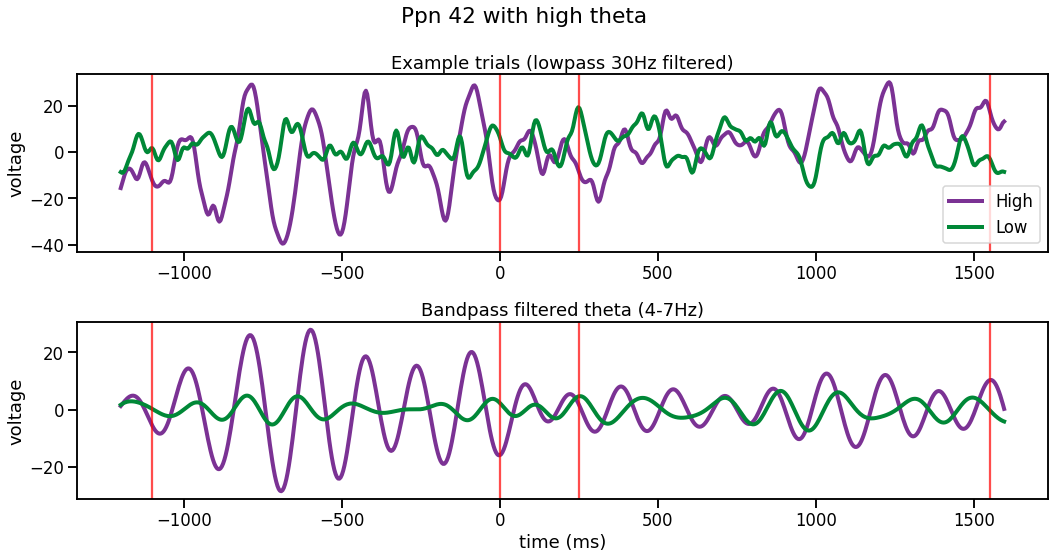

In [45]:
file_eeg = '42_EEG_timeLockMem.mat'
eeg = mat73.loadmat(eeg_dat_path + file_eeg)

plot_high_low(eeg, n_idx=1, title='Ppn 42 with high theta ')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/fooof/objs/group.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for index, data in enumerate(self.group_results)])


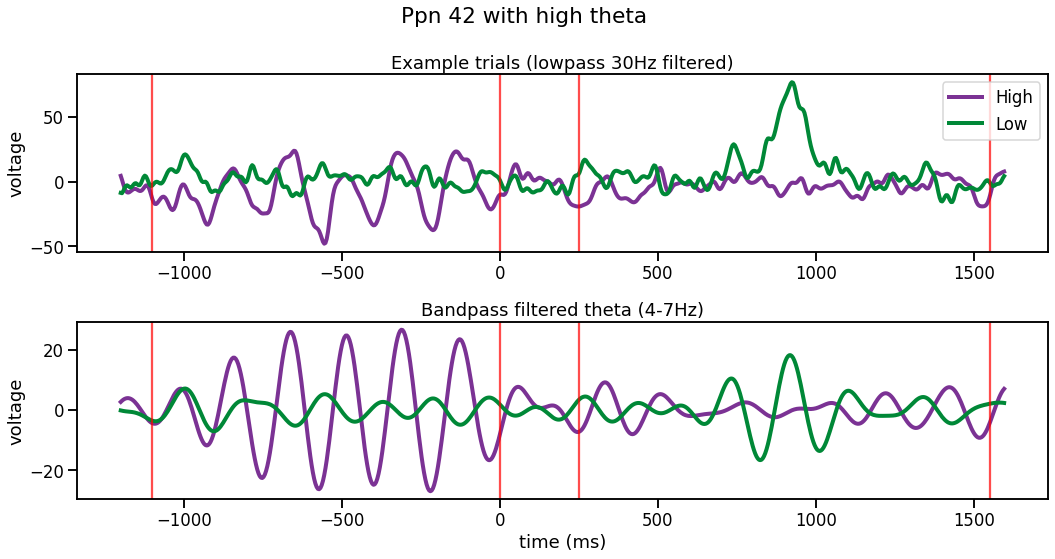

In [47]:
plot_high_low(eeg, n_idx=0, title='Ppn 42 with high theta ')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/fooof/objs/group.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for index, data in enumerate(self.group_results)])


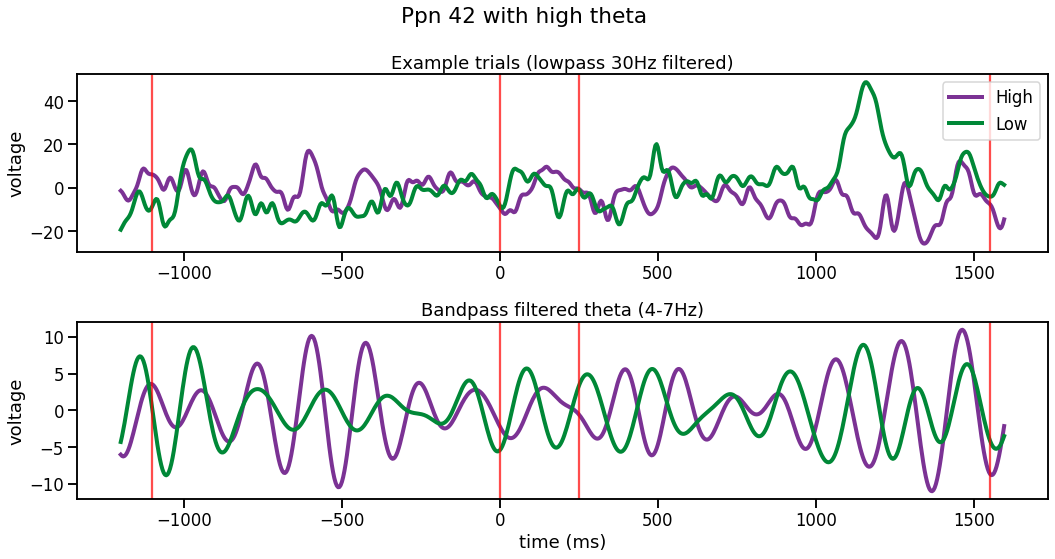

In [46]:
plot_high_low(eeg, n_idx=2, title='Ppn 42 with high theta ')

<div>
<img src="../saved_files/exp2_check_peak/ppn_30_psd_model.jpeg" width="300"/>
</div>

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/fooof/objs/group.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for index, data in enumerate(self.group_results)])


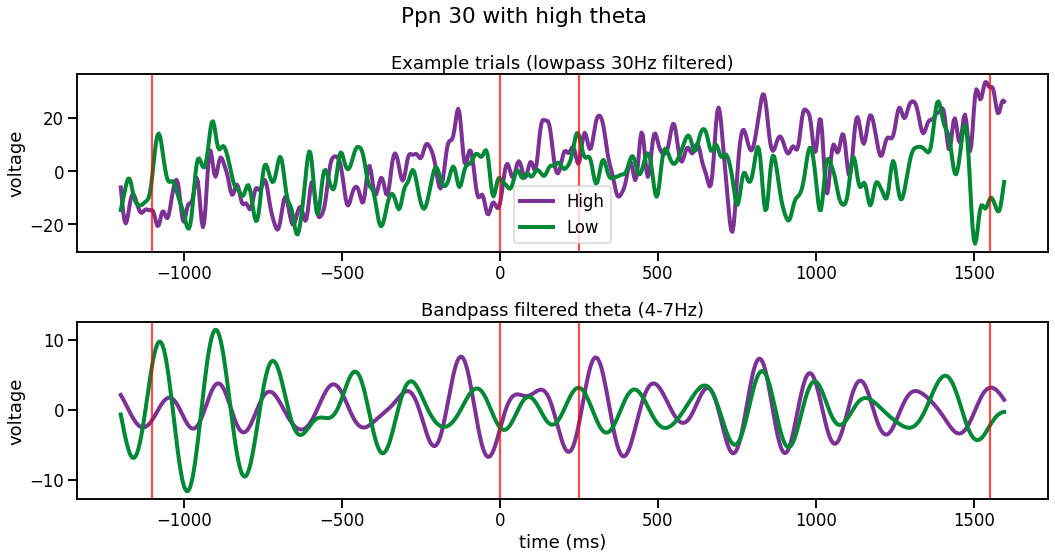

In [48]:
file_eeg = '30_EEG_timeLockMem.mat'
eeg = mat73.loadmat(eeg_dat_path + file_eeg)

plot_high_low(eeg, n_idx=0, title='Ppn 30 with high theta ')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/fooof/objs/group.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for index, data in enumerate(self.group_results)])


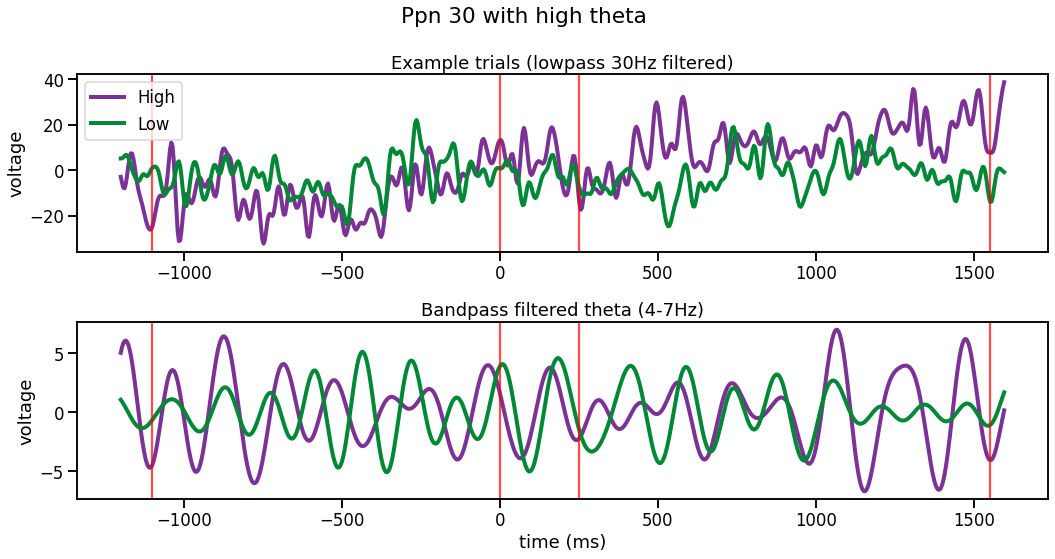

In [50]:
plot_high_low(eeg, n_idx=1, title='Ppn 30 with high theta ')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/fooof/objs/group.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for index, data in enumerate(self.group_results)])


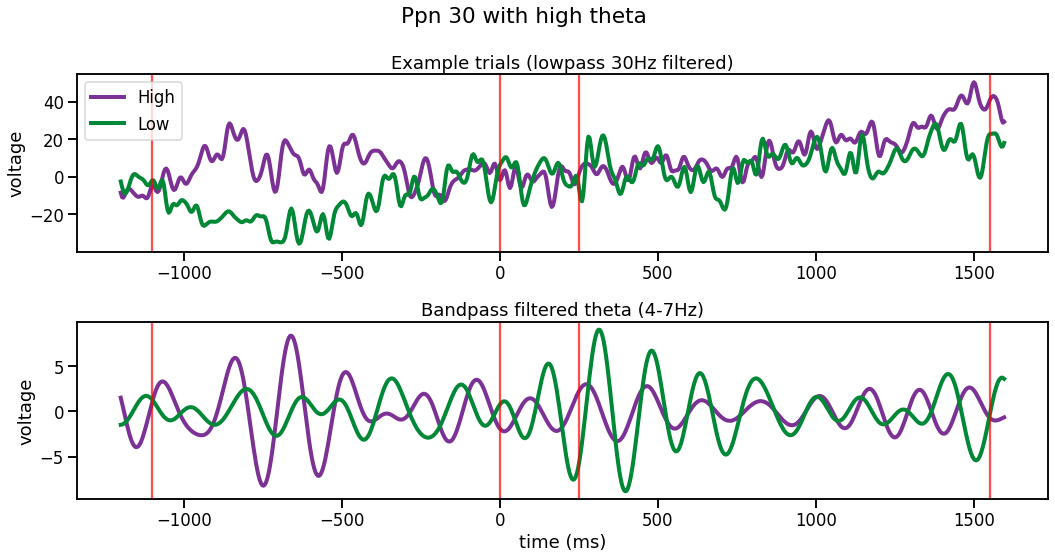

In [49]:
plot_high_low(eeg, n_idx=2, title='Ppn 30 with high theta ')

<div>
<img src="../saved_files/exp2_check_peak/ppn_41_psd_model.jpeg" width="300"/>
</div>

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/fooof/objs/group.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for index, data in enumerate(self.group_results)])


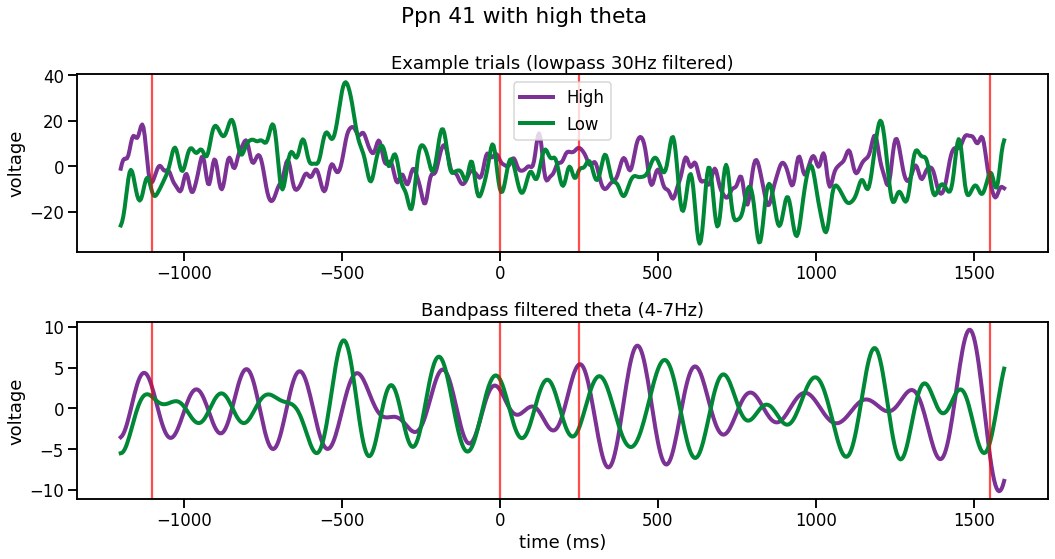

In [51]:
file_eeg = '41_EEG_timeLockMem.mat'
eeg = mat73.loadmat(eeg_dat_path + file_eeg)

plot_high_low(eeg, n_idx=0, title='Ppn 41 with high theta ')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/fooof/objs/group.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for index, data in enumerate(self.group_results)])


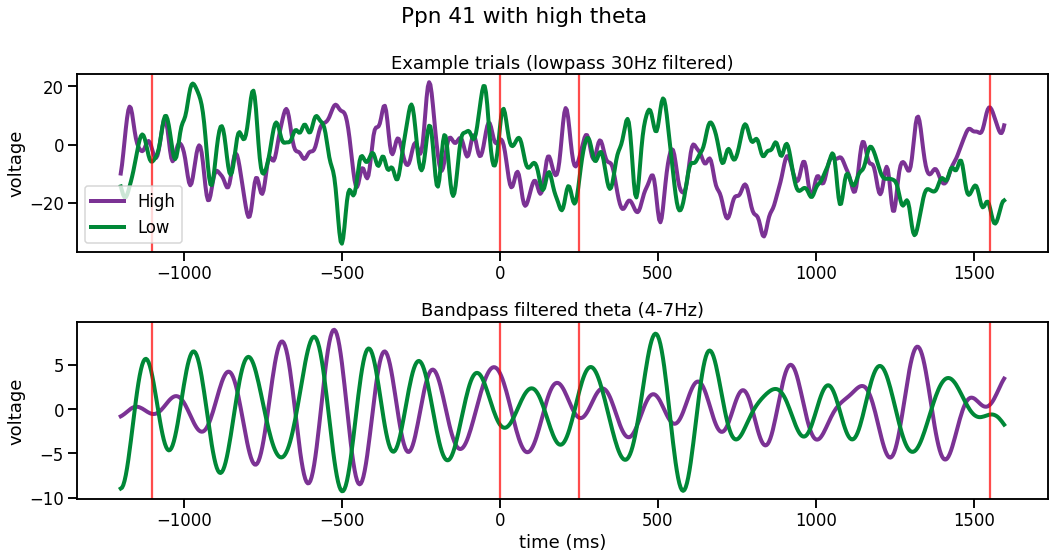

In [53]:
plot_high_low(eeg, n_idx=1, title='Ppn 41 with high theta ')

/Users/quirine/opt/anaconda3/envs/py3/lib/python3.7/site-packages/fooof/objs/group.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for index, data in enumerate(self.group_results)])


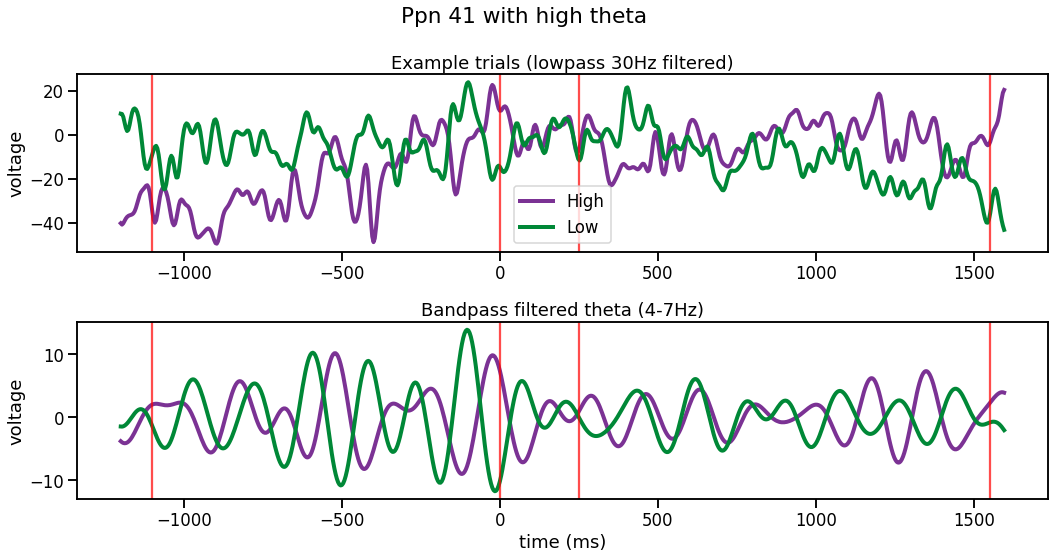

In [52]:
plot_high_low(eeg, n_idx=2, title='Ppn 41 with high theta ')

# REFERENCE CODE

In [22]:
for key in beh:
    print(key)

NameError: name 'beh' is not defined

In [23]:
for key in eeg['eeg']:
    print(key)

arf
basefiltbase
baselined
chanLabels
conditionCodes
conditionLabels
data
settings
time
time_long


In [24]:
sfreq = int(eeg['eeg']['settings']['srate'])

In [25]:
time_axis_long = eeg['eeg']['time_long']

In [26]:
idx = np.where(time_axis_long == START_BAS)[0][0]
time_axis_long[idx]

-1100.0

In [27]:
idx

225

In [28]:
eeg['eeg']['data'].shape # 6 conditions (ipsi/contra/ * 3 set sizes or performance); 100 trials per condition; 22 channels as in chanLabels; 988 timepoints

(2, 270, 22, 1013)

In [29]:
eeg['eeg']['chanLabels'] # --> Fz = 18; F3 = 2; F4 = 3

['PO3',
 'PO4',
 'F3',
 'F4',
 'C3',
 'C4',
 'P3',
 'P4',
 'O1',
 'O2',
 'OL',
 'OR',
 'T3',
 'T4',
 'T5',
 'T6',
 'POz',
 'Cz',
 'Fz',
 'Pz',
 'VEOG',
 'HEOG']

In [30]:
sfreq

250

In [31]:
eeg_fz = eeg['eeg']['data'][0, :, 18, :]
eeg_f3 = eeg['eeg']['data'][0, :, 2, :]
eeg_f4 = eeg['eeg']['data'][0, :, 3, :]

In [32]:
eeg_fz.shape

(270, 1013)

In [33]:
time_min200 = np.where(time_axis_long == -200)[0][0]
time_0 = np.where(time_axis_long == 0)[0][0]

In [34]:
eeg_fz_bas_period = eeg_fz[:, time_min200:time_0].mean(axis=1)
eeg_fz_bas = eeg_fz - eeg_fz_bas_period.reshape(-1,1)

eeg_f3_bas_period = eeg_f3[:, time_min200:time_0].mean(axis=1)
eeg_f3_bas = eeg_fz - eeg_f3_bas_period.reshape(-1,1)

eeg_f4_bas_period = eeg_f4[:, time_min200:time_0].mean(axis=1)
eeg_f4_bas = eeg_fz - eeg_f4_bas_period.reshape(-1,1)

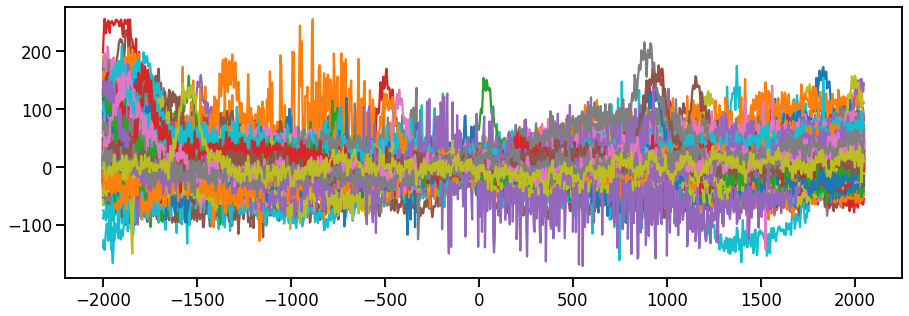

In [35]:
plt.plot(time_axis_long, eeg_fz_bas.T)
plt.show()

### Specparam the data and see whether there is a theta peak in a trial

In [36]:
freq_fz, psd_fz = spectral.compute_spectrum(eeg_fz_bas, sfreq,
            method = 'welch', avg_type = 'mean', nperseg = sfreq)

freq_f3, psd_f3 = spectral.compute_spectrum(eeg_f3_bas, sfreq,
            method = 'welch', avg_type = 'mean', nperseg = sfreq)

freq_f4, psd_f4 = spectral.compute_spectrum(eeg_f4_bas, sfreq,
            method = 'welch', avg_type = 'mean', nperseg = sfreq)

In [38]:
# eeg_fz_bas
eeg_fz_bas[~np.isnan(eeg_fz_bas).any(axis=1)]


array([[-10.81820273,  -2.20083305,  11.52220364, ...,  23.84221964,
         42.71243282,  37.96374741],
       [  7.87650834,   0.40480053,   0.07272462, ...,  -4.79218735,
         17.33236968,  21.82369626],
       [  8.95110596,  15.29375571,  20.23338476, ...,  30.32019031,
         35.17680039,  26.99112939],
       ...,
       [ 20.64864568,  -1.70836448,  16.4810931 , ...,  20.75657035,
         44.44188412,  54.62831244],
       [ -2.63784493,   8.03839534,   2.73348279, ...,  14.28142232,
         21.62860167,   9.60745398],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

In [37]:
# initialize fooof + set settings
fg = FOOOFGroup(**SETS)

# Fooof it
fg.fit(freq_fz, psd_fz, FREQ_RANGE, n_jobs= -1)

# Find Peak heights
periodic_theta = get_band_peak_fg(fg, THETA) # periodic params (cf, power, bandwidth)
theta_power = periodic_theta[:,1]
periodic_alpha = get_band_peak_fg(fg, ALPHA) # periodic params (cf, power, bandwidth)
alpha_power = periodic_alpha[:,1]

# Clean the data --> NaN to 0
theta_power_cl = np.nan_to_num(theta_power)
alpha_power_cl = np.nan_to_num(alpha_power)

# Get indices of the 10 trials with highest theta power (according to specparam)
n = 10
theta_high_10 = np.argpartition(theta_power_cl, n)[-n:]
theta_low_10 = np.random.choice(np.where(theta_power_cl == 0)[0], size=n, replace=False)

alpha_high_10 = np.argpartition(alpha_power_cl, n)[-n:]
alpha_low_10 = np.random.choice(np.where(alpha_power_cl == 0)[0], size=n, replace=False)

DataError: The input power spectra data, after logging, contains NaNs or Infs. This will cause the fitting to fail. One reason this can happen is if inputs are already logged. Inputs data should be in linear spacing, not log.

In [ ]:
time_min1200 = np.where(time_axis_long == -1200)[0][0]
time_plus1600 = np.where(time_axis_long == 1600)[0][0]

# low pass filter to get rid of high freq noise
eeg_fz_bas_low = filt.filter_signal(eeg_fz_bas, sfreq, pass_type='lowpass', f_range=30,
                                    filter_type='fir', n_cycles=3, remove_edges=True)

eeg_fz_bas_theta = filt.filter_signal(eeg_fz_bas, sfreq, pass_type='bandpass', f_range=THETA, 
                                    filter_type='fir', n_cycles=3, remove_edges=True)

eeg_fz_bas_alpha = filt.filter_signal(eeg_fz_bas, sfreq, pass_type='bandpass', f_range=ALPHA, 
                                    filter_type='fir', n_cycles=3, remove_edges=True)

low_high = eeg_fz_bas_low[idx_high_10, time_min1200:time_plus1600]
theta_high = eeg_fz_bas_theta[idx_high_10, time_min1200:time_plus1600]
alpha_high = eeg_fz_bas_alpha[idx_high_10, time_min1200:time_plus1600]

low_low = eeg_fz_bas_low[idx_low_10, time_min1200:time_plus1600]
theta_low = eeg_fz_bas_theta[idx_low_10, time_min1200:time_plus1600]
alpha_low = eeg_fz_bas_alpha[idx_low_10, time_min1200:time_plus1600]

In [ ]:
fz_theta_high = eeg_fz_bas_low[idx_high_10]
fz_theta_low = eeg_fz_bas_low[idx_low_10]

In [ ]:
# plot three graphs at once

time_axis_cut = time_axis_long[time_min1200:time_plus1600]

fig, ax = plt.subplots(2, figsize=(15, 8))

ax[0].plot(time_axis_cut, low_high[0], color='black')
ax[0].plot(time_axis_cut, theta_high[0], color='gray')
ax[1].plot(time_axis_cut, low_low[0], color='black')
ax[1].plot(time_axis_cut, theta_low[0], color='gray')

# add vertical lines
ax[0].axvline(x=-1100, ymin=-20, ymax=60, color='red', alpha=0.7)
ax[0].axvline(x=0, ymin=-20, ymax=60, color='red', alpha=0.7)
ax[0].axvline(x=250, ymin=-20, ymax=60, color='red', alpha=0.7)
ax[0].axvline(x=1550, ymin=-20, ymax=60, color='red', alpha=0.7)
ax[1].axvline(x=-1100, ymin=-20, ymax=60, color='red', alpha=0.7)
ax[1].axvline(x=0, ymin=-20, ymax=60, color='red', alpha=0.7)
ax[1].axvline(x=250, ymin=-20, ymax=60, color='red', alpha=0.7)
ax[1].axvline(x=1550, ymin=-20, ymax=60, color='red', alpha=0.7)



ax[0].set_title('blabla')
ax[1].set_title('blabla2')
fig.suptitle('Cool science happening here')
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(time_axis_long, fz_high[0])
plt.plot(time_axis_long, fz_low[0])
plt.xlim([-1100, 1800])
plt.title('high theta power vs low alpha power')
plt.show()

In [ ]:
plt.plot(time_axis_long, fz_high[1])
plt.plot(time_axis_long, fz_low[1])
plt.xlim([-1100, 1800])
plt.title('high theta power vs low alpha power')
plt.show()

In [ ]:
plt.plot(time_axis_long, fz_high[3])
plt.plot(time_axis_long, fz_low[3])
plt.xlim([-1100, 1800])
plt.title('high theta power vs low alpha power')
plt.show()

## Compare with alpha oscillations. Just for shits and giggles

Ppn 1 of Experiment 2 shows a clear peak in theta and alpha range

In [ ]:
periodic = get_band_peak_fg(fg, ALPHA) # periodic params (cf, power, bandwidth)
alpha_power = periodic[:,1]
alpha_power_cl = np.nan_to_num(alpha_power)

# Get indices of the 10 trials with highest theta power (according to specparam)
n = 10
idx_high_10 = np.argpartition(alpha_power_cl, n)[-n:]
idx_low_10 = np.random.choice(np.where(alpha_power_cl == 0)[0], size=n, replace=False)

# low pass filter to get rid of high freq noise
# eeg_fz_bas_filt = filt.filter_signal(eeg_fz_bas, sfreq, pass_type='lowpass', f_range=30, 
#                                     filter_type='fir', n_cycles=3, remove_edges=True)

fz_high = eeg_fz_bas_filt[idx_high_10]
fz_low = eeg_fz_bas_filt[idx_low_10]


In [ ]:
plt.plot(time_axis_long, fz_high[0])
plt.plot(time_axis_long, fz_low[0])
plt.xlim([-1100, 1800])
plt.title('high alpha power vs low alpha power')
plt.show()